# Phishing Model Prototype

In [1]:
%pip install numpy
%pip install pandas
%pip install joblib
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install scipy
%pip install jupyter
%pip install nltk
%pip install num2words
%pip install spacy
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------------------------------ -------- 10.0/12.8 MB 52.6 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 50.2 MB/s  0:00:00
✔ Download and installation successful
You c

In [2]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator, TransformerMixin

import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.cluster import HDBSCAN

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import pairwise_distances

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D # for 3D plots

from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
import num2words

import spacy
import sys
!{sys.executable} -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## 1. Data

In [3]:
data = "./data/small.csv"

emails = pd.read_csv(data, sep=",", encoding="UTF-8")

df_emails = emails.copy()

df_emails.shape

(5, 7)

In [4]:
df_emails.sample(5)

,sender,receiver,date,subject,body,urls,label
0,Mail System Internal Data <MAILER-DAEMON@monke...,NaN,28 Sep 2017 09:57:25 -0400,DON'T DELETE THIS MESSAGE -- FOLDER INTERNAL DATA,This text is part of the internal format of yo...,1,1
4,"""USAA"" <usaaacctupdate@sccu4u.com>",Recipients <usaaacctupdate@sccu4u.com>,"Fri, 30 Oct 2015 14:02:33 -0500",Final USAA Reminder - Update Your Account Now,"To ensure delivery to your inbox, please add U...",1,1
1,cPanel <service@cpanel.com>,jose@monkey.org,"Fri, 30 Oct 2015 00:00:48 -0500",Verify Your Account,Business with \t\t\t\t\t\t\t\tcPanel & WHM \t...,1,1
3,Ann Garcia <AnGarcia@mcoe.org>,"""info@maaaaa.org"" <info@maaaaa.org>","Fri, 30 Oct 2015 14:54:33 +0000",IT-Service Help Desk,Password will expire in 3 days. Click Here To ...,0,1
2,Microsoft Outlook <recepcao@unimedceara.com.br>,NaN,"Fri, 30 Oct 2015 06:21:59 -0300 (BRT)",Helpdesk Mailbox Alert!!!,Your two incoming mails were placed on pending...,1,1


In [5]:
df_emails.dtypes

sender      object
receiver    object
date        object
subject     object
body        object
urls         int64
label        int64
dtype: object

## 2. Data Understanding

In [6]:
df_emails.describe()

,urls,label
count,5.000000,5.0
mean,0.800000,1.0
std,0.447214,0.0
min,0.000000,1.0
25%,1.000000,1.0
50%,1.000000,1.0
75%,1.000000,1.0
max,1.000000,1.0


### Emptyness

In [7]:
df_percentages = (100*df_emails.isna().sum()/len(df_emails)).to_frame()
df_percentages.sort_values(0, ascending = False)

,0
receiver,40.0
sender,0.0
date,0.0
subject,0.0
body,0.0
urls,0.0
label,0.0


### Duplicates

In [8]:
df_duplicated = df_emails.loc[df_emails.duplicated(keep=False)]
df_duplicated

,sender,receiver,date,subject,body,urls,label


## 3. Data Transformations

### Drop Empty & Duplicate

In [9]:
def drop_empty(dataframe):

    dataframe.dropna(inplace=True)

    return

drop_empty(df_emails)

df_emails.shape

(3, 7)

### Data Cleaning

In [10]:
def clean_ascii(df_emails):
    df_emails["sender"] = df_emails["sender"].apply(lambda x: x.encode("ascii", "ignore").decode() if isinstance(x, str) else x)
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: x.encode("ascii", "ignore").decode() if isinstance(x, str) else x)
    df_emails["date"] = df_emails["date"].apply(lambda x: x.encode("ascii", "ignore").decode() if isinstance(x, str) else x)
    df_emails["subject"] = df_emails["subject"].apply(lambda x: x.encode("ascii", "ignore").decode() if isinstance(x, str) else x)
    df_emails["body"] = df_emails["body"].apply(lambda x: x.encode("ascii", "ignore").decode() if isinstance(x, str) else x)

    return

def clean_upper_case(df_emails):
    df_emails["sender"] = df_emails["sender"].str.lower()
    df_emails["receiver"] = df_emails["receiver"].str.lower()
    df_emails["date"] = df_emails["date"].str.lower()
    df_emails["subject"] = df_emails["subject"].str.lower()
    df_emails["body"] = df_emails["body"].str.lower()

    return

def clean_punctuation(df_emails):
    df_emails["sender"] = df_emails["sender"].apply(lambda x: re.sub(r'[.:,;-_¿?¡!"\'()\[\]{}\/%\$@+*\^]', '', x))
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: re.sub(r'[.:,;-_¿?¡!"\'()\[\]{}\/%\$@+*\^]', '', x))
    df_emails["date"] = df_emails["date"].apply(lambda x: re.sub(r'[.:,;-_¿?¡!"\'()\[\]{}\/%\$@+*\^]', '', x))
    df_emails["subject"] = df_emails["subject"].apply(lambda x: re.sub(r'[.:,;-_¿?¡!"\'()\[\]{}\/%\$@+*\^]', '', x))
    df_emails["body"] = df_emails["body"].apply(lambda x: re.sub(r'[.:,;-_¿?¡!"\'()\[\]{}\/%\$@+*\^]', '', x))

    return

def clean_numbers(df_emails):
    df_emails["sender"] = df_emails["sender"].apply(lambda x: re.sub(r'\b\d+\b', lambda y: num2words.num2words(y.group(), lang='en'), x))
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: re.sub(r'\b\d+\b', lambda y: num2words.num2words(y.group(), lang='en'), x))
    df_emails["date"] = df_emails["date"].apply(lambda x: re.sub(r'\b\d+\b', lambda y: num2words.num2words(y.group(), lang='en'), x))
    df_emails["subject"] = df_emails["subject"].apply(lambda x: re.sub(r'\b\d+\b', lambda y: num2words.num2words(y.group(), lang='en'), x))
    df_emails["body"] = df_emails["body"].apply(lambda x: re.sub(r'\b\d+\b', lambda y: num2words.num2words(y.group(), lang='en'), x))

    return

def clena_stopwords(df_emails):
    stop_words = set(stopwords.words('english'))

    df_emails["sender"] = df_emails["sender"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    df_emails["date"] = df_emails["date"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    df_emails["subject"] = df_emails["subject"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    df_emails["body"] = df_emails["body"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    return

def clean_sidebar(df_emails):
    df_emails["sender"] = df_emails["sender"].apply(lambda x: x.replace("-", " "))
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: x.replace("-", " "))
    df_emails["date"] = df_emails["date"].apply(lambda x: x.replace("-", " "))
    df_emails["subject"] = df_emails["subject"].apply(lambda x: x.replace("-", " "))
    df_emails["body"] = df_emails["body"].apply(lambda x: x.replace("-", " "))

    return

numbers_post_ascii = r'[0123456789]'

def clean_numbers_post_ascii(df_emails):
    df_emails["sender"] = df_emails["sender"].apply(lambda x: re.sub(numbers_post_ascii, '', x))
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: re.sub(numbers_post_ascii, '', x))
    df_emails["date"] = df_emails["date"].apply(lambda x: re.sub(numbers_post_ascii, '', x))
    df_emails["subject"] = df_emails["subject"].apply(lambda x: re.sub(numbers_post_ascii, '', x))
    df_emails["body"] = df_emails["body"].apply(lambda x: re.sub(numbers_post_ascii, '', x))

    return


In [11]:
def clean_text(df_emails):

    clean_ascii(df_emails)
    clean_upper_case(df_emails)
    clean_punctuation(df_emails)
    clean_numbers(df_emails)
    clena_stopwords(df_emails)
    clean_sidebar(df_emails)
    clean_numbers_post_ascii(df_emails)

    return

clean_text(df_emails)
print(df_emails)

                        sender                           receiver  \
1      cpanel servicecpanelcom                      josemonkeyorg   
3   ann garcia angarciamcoeorg        infomaaaaaorg infomaaaaaorg   
4  usaa usaaacctupdatesccuucom  recipients usaaacctupdatesccuucom   

                                                date  \
1  fri thirty oct two thousand fifteen forty eigh...   
3  fri thirty oct two thousand fifteen one hundre...   
4  fri thirty oct two thousand fifteen one hundre...   

                                subject  \
1                        verify account   
3                  it service help desk   
4  final usaa reminder   update account   

                                                body  urls  label  
1  business cpanel & whm dear client technical se...     1      1  
3  password expire three days click validate e ma...     0      1  
4  ensure delivery inbox please add usaacustomers...     1      1  


### Bag Of Words

In [12]:
def tokenize_text(df_emails):

    df_emails["sender_T"] = df_emails["sender"].apply(lambda x: [token.text for token in nlp(x) if not token.is_space])
    df_emails["receiver_T"] = df_emails["receiver"].apply(lambda x: [token.text for token in nlp(x) if not token.is_space])
    df_emails["date_T"] = df_emails["date"].apply(lambda x: [token.text for token in nlp(x) if not token.is_space])
    df_emails["subject_T"] = df_emails["subject"].apply(lambda x: [token.text for token in nlp(x) if not token.is_space])
    df_emails["body_T"] = df_emails["body"].apply(lambda x: [token.text for token in nlp(x) if not token.is_space])

    return

In [13]:
vectorizer = CountVectorizer()

def vectorize_tokens(df_emails):

    email_plain_text = df_emails['sender_T'].astype('str') + ""  + df_emails['receiver_T'].astype('str') + " " + df_emails['date_T'].astype('str') + " " + df_emails['subject_T'].astype('str') + " " + df_emails['body_T'].astype('str')

    df_vectorized = vectorizer.fit_transform(email_plain_text)

    return df_vectorized

In [14]:
def prepare_text(df_emails):

    tokenize_text(df_emails)
    X = vectorize_tokens(df_emails)

    return X

In [15]:
X = prepare_text(df_emails)

print(X)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 212 stored elements and shape (3, 177)>
  Coords	Values
  (0, 27)	2
  (0, 130)	1
  (0, 66)	1
  (0, 55)	1
  (0, 146)	1
  (0, 91)	1
  (0, 153)	2
  (0, 147)	2
  (0, 47)	2
  (0, 52)	1
  (0, 41)	1
  (0, 49)	1
  (0, 58)	1
  (0, 168)	1
  (0, 2)	2
  (0, 16)	1
  (0, 171)	1
  (0, 32)	1
  (0, 21)	1
  (0, 142)	1
  (0, 131)	1
  (0, 35)	1
  (0, 18)	1
  (0, 100)	1
  (0, 137)	1
  :	:
  (2, 156)	2
  (2, 83)	2
  (2, 108)	2
  (2, 24)	2
  (2, 117)	2
  (2, 109)	2
  (2, 17)	2
  (2, 133)	3
  (2, 132)	2
  (2, 134)	2
  (2, 124)	2
  (2, 107)	2
  (2, 87)	5
  (2, 54)	1
  (2, 121)	1
  (2, 123)	1
  (2, 11)	1
  (2, 143)	1
  (2, 42)	1
  (2, 114)	2
  (2, 170)	2
  (2, 126)	2
  (2, 152)	2
  (2, 33)	1
  (2, 163)	1


## 4. Unsupervised Model

In [16]:
kmeans_clusters = KMeans(n_clusters=2)
kmeans_clusters.fit(X)

,n_clusters,2
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [17]:
labels = kmeans_clusters.labels_
print(labels)

[0 0 1]


<Axes: xlabel='Cluster_KMeans'>

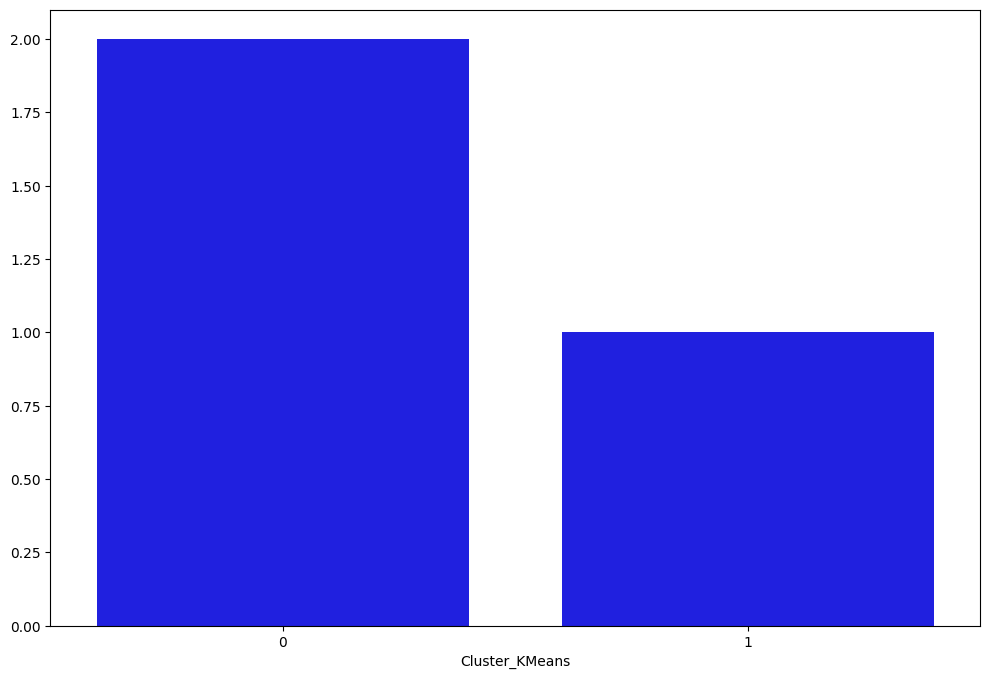

In [18]:
df_kmeans = df_emails.copy()
df_kmeans["Cluster_KMeans"] = labels

cluster_distrib_kmeans = df_kmeans["Cluster_KMeans"].value_counts()

fig=plt.figure(figsize=(12,8))
sns.barplot(x=cluster_distrib_kmeans.index, y=cluster_distrib_kmeans.values, color='b')

## 5. Graphical Visualization

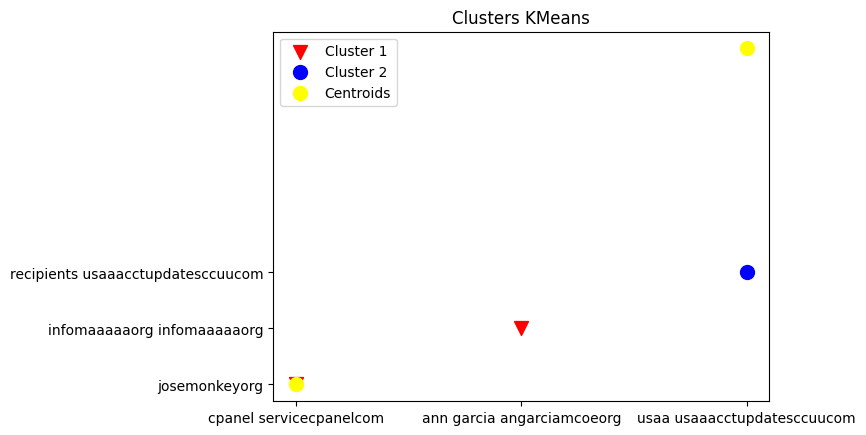

In [19]:
col = df_kmeans.to_numpy()

plt.scatter(col[kmeans_clusters.labels_ == 0, 0], col[kmeans_clusters.labels_ == 0, 1], s = 100, marker='v', c = 'red', label = 'Cluster 1')
plt.scatter(col[kmeans_clusters.labels_ == 1, 0], col[kmeans_clusters.labels_ == 1, 1], s = 100, marker='o', c = 'blue', label = 'Cluster 2')

plt.scatter(kmeans_clusters.cluster_centers_[:, 0], kmeans_clusters.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Clusters KMeans')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm

cluster_labels = np.unique(df_kmeans["Cluster_KMeans"])

n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(df_kmeans, kmeans_clusters.labels_, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[labels == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
                        c_silhouette_vals,
                        height=1.0,
                        edgecolor='none',
                        color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
            color="red",
            linestyle="--")
plt.yticks(yticks, cluster_labels+1)
plt.title("Siluetas")
plt.show()

ValueError: could not convert string to float: 'cpanel servicecpanelcom'

In [ ]:
inertia = []
df_kmeans = df_emails.copy()
for i in range(1, 15):
    km = KMeans(n_clusters=i)
    km.fit(df_kmeans)
    inertia.append(km.inertia_)

plt.plot(range(1,15), inertia, marker='o')
plt.xlabel("Number Groups")
plt.ylabel("Inertia")
plt.show()

In [ ]:
silhouette = []
for i in range(2, 10):
    km = KMeans(n_clusters=i)
    km.fit(df_kmeans)
    silhouette.append(silhouette_score(df_kmeans, km.labels_))

plt.plot(range(2,10), silhouette, marker='o')
plt.xlabel("Number Groups")
plt.ylabel("Silhouette")
plt.show()